In [3]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import scipy.io #Used to load the OCTAVE *.mat files
import scipy.misc #Used to show matrix as an image
import matplotlib.cm as cm #Used to display images in a specific colormap
import random #To pick random images to display
import scipy.optimize #fmin_cg to train neural network
import itertools
from scipy.special import expit #Vectorized sigmoid function

In [4]:
cd C:\Users\诚明\Desktop\MachineLearning\machine-learning-ex4\ex4

C:\Users\诚明\Desktop\MachineLearning\machine-learning-ex4\ex4


In [5]:
data=scipy.io.loadmat("ex4data1.mat")

In [6]:
X,y=data['X'],data['y']
n=y.size

In [7]:
X=np.insert(X,0,1,axis=1)

In [8]:
print('shape of X: %s \nshape of y: %s' % (X.shape,y.shape))

shape of X: (5000, 401) 
shape of y: (5000, 1)


# 1. Visualize Dataset

In [7]:
def getpixels(row):
    square=row[1:].reshape((20,20))
    return square.T

In [8]:
def displayData(indices=None):
    if not indices:
        indices=random.sample(list(range(X.shape[0])),10*10)
    m=np.zeros((20*10,20*10))
    icol,irow=0,0
    for i in indices:
        if icol==10:
            irow+=1
            icol=0
        img=getpixels(X[i])
        m[irow*20:irow*20+img.shape[0],icol*20:icol*20+img.shape[1]]=img
        icol+=1
    fig=plt.figure(figsize=(8,8))
    plt.imshow(m,cmap=cm.Greys_r)
    plt.axis('off')

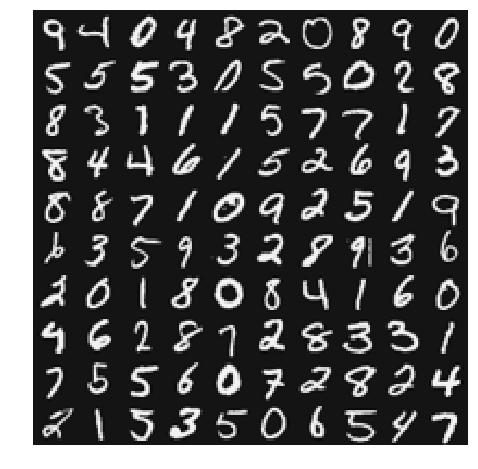

In [9]:
displayData()

In [10]:
mat=scipy.io.loadmat('ex4weights.mat')

In [11]:
Theta1,Theta2=mat['Theta1'],mat['Theta2']

In [12]:
print('shape of Theta1: %s \nshape of Theta2: %s' % (Theta1.shape,Theta2.shape))

shape of Theta1: (25, 401) 
shape of Theta2: (10, 26)


# Preparation: Flatten, Reshape Dataset and Theta

In [13]:
input_layer_size=400
hidden_layer_size=25
output_layer_size=10 

def flattenParameters(theta_list):
    flattened_list=[theta.flatten() for theta in theta_list]
    combined = list(itertools.chain.from_iterable(flattened_list))               
    assert len(combined) == (input_layer_size+1)*hidden_layer_size + (hidden_layer_size+1)*output_layer_size
    return np.array(combined).reshape((len(combined),1))                                             

In [14]:
def reshapeParameters(flattened_array):
    sep1=flattened_array[:(input_layer_size+1)*hidden_layer_size]
    sep2=flattened_array[(input_layer_size+1)*hidden_layer_size:]
    theta1=sep1.reshape((hidden_layer_size,input_layer_size+1))
    theta2=sep2.reshape((output_layer_size,hidden_layer_size+1))
    return [theta1,theta2]

In [15]:
def flattenX(x):
    return np.array(x.flatten()).reshape((n*(input_layer_size+1),1))

def reshapeX(x):
    return np.array(x).reshape((n,input_layer_size+1))

# 2. Randomly initialize Thetas and Compute Cost Function using Forwardpropagation

In [90]:
def computecost(flattened_theta,flattened_x,y,lam=0):
    thetas=reshapeParameters(flattened_theta)
    x=reshapeX(flattened_x)
    m=n
    total_cost=0
    for i in range(m):
        row=x[i].reshape((input_layer_size+1,1))
        temp=forwardpropagate(thetas,row)
        yy=np.zeros((10,1))
        yy[y[i]-1]=1
        total_cost-=yy.T.dot(np.log(temp[1][1]))+(1-yy.T).dot(np.log(1-temp[1,1]))
    
    rem=0
    for th in thetas:
        rem+=np.sum(th[:,1:]**2)
    return float(total_cost/m)+float(rem*lam/m/2)

In [17]:
# Forwardpropagation computes each z and a(the same as h)

def forwardpropagate(thetas,row):
    features=row
    zs_hs=[]
    for i in range(len(thetas)):
        theta=thetas[i]
        z=theta.dot(features).reshape((theta.shape[0],1))
        a=expit(z)
        zs_hs.append((z,a))
        if i==len(thetas)-1:
            return np.array(zs_hs)
        a=np.insert(a,0,1,axis=0)
        features=a

In [18]:
thetas=[Theta1,Theta2]

In [92]:
computecost(flattenParameters(thetas),flattenX(X),y)

0.2876291651613188

In [91]:
computecost(flattenParameters(thetas),flattenX(X),y,lam=1)

0.38376985909092354

# 3. Backpropergation to compute the gradient of cost function

In [21]:
def sigmoidgradient(z):
    return expit(z)*(1-expit(z))

In [22]:
def genrandTheta():
    epsilon=0.12
    theta1_shape=(hidden_layer_size,input_layer_size+1)
    theta2_shape=(output_layer_size,hidden_layer_size+1)
    rand_thetas=[np.random.rand(*theta1_shape)*2*epsilon-epsilon,np.random.rand(*theta2_shape)*2*epsilon-epsilon]
    return rand_thetas

In [94]:
def backpropergation(flattened_theta,flattened_x,y,lam=0):
    thetas=reshapeParameters(flattened_theta)
    x=reshapeX(flattened_x)
    Delta1=np.zeros((hidden_layer_size,input_layer_size+1))
    Delta2=np.zeros((output_layer_size,hidden_layer_size+1))
    m=n
    for i in range(m):
        a1=x[i].reshape((x.shape[1],1))
        temp=forwardpropagate(thetas,x[i])           # Use forward propagation to compute z and a for each training sample
        a2=temp[0][1]
        z2=temp[0][0]
        a3=temp[1][1]
        z3=temp[1][0]
        yy=np.zeros((10,1))
        yy[y[i]-1]=1
        delta3=a3-yy
        delta2=rand_thetas[1][:,1:].T.dot(delta3)*sigmoidgradient(z2)
        a2=np.insert(a2,0,1,axis=0)
        Delta1+=delta2.dot(a1.T)
        Delta2+=delta3.dot(a2.T)
    
    D1=Delta1/m
    D2=Delta2/m
    
    D1[:,1:]=D1[:,1:]+lam/m*thetas[0][:,1:]
    D2[:,1:]=D2[:,1:]+lam/m*thetas[1][:,1:]
    return flattenParameters([D1,D2]).flatten()

In [110]:
rand_thetas=genrandTheta()

In [111]:
flattenedD1D2=backpropergation(flattenParameters(rand_thetas),flattenX(X),y)

In [112]:
D1,D2=reshapeParameters(flattenedD1D2)

In [113]:
def checkgradient(thetas,D,x,y,lam=0):
    eps=0.0001
    flattened=flattenParameters(thetas)
    flattenedD=flattenParameters(D)
    flattenedX=flattenX(x)
    n=len(flattened)
    for i in range(10):
        k=int(np.random.rand()*n)
        epsvec=np.zeros((n,1))
        epsvec[k]=eps
        f=(computecost(flattened+epsvec,flattenedX,y)-computecost(flattened-epsvec,flattenedX,y))/2/eps
        print('f=%.4f   gradient=%.4f    error=%s' % (f,flattenedD[k],float(flattenedD[k]-f)))

In [114]:
checkgradient(rand_thetas,[D1,D2],X,y)

f=0.0000   gradient=0.0000    error=-3.360987288142482e-12
f=0.0002   gradient=0.0002    error=-1.5833578643088125e-11
f=-0.0134   gradient=-0.0134    error=-3.4816332109000037e-11
f=-0.0000   gradient=-0.0000    error=-1.0251735484235683e-11
f=0.1946   gradient=0.1946    error=1.3056972170133463e-10
f=0.0000   gradient=0.0000    error=7.644703132149205e-12
f=0.0000   gradient=0.0000    error=6.450925282166608e-12
f=-0.0012   gradient=-0.0012    error=6.276259113119353e-11
f=-0.0002   gradient=-0.0002    error=7.508343043984532e-11
f=-0.0000   gradient=-0.0000    error=1.961167373094717e-11


# 4. Train thetas by using gradient descent or other optimization algorithm

In [132]:
def trainNN(thetas,x,y,lam=0):
    result=scipy.optimize.fmin_cg(computecost,x0=flattenParameters(thetas),fprime=backpropergation,args=(flattenX(x),y,lam),maxiter=50,\
                                  disp=True,full_output=True)
    return reshapeParameters(result[0])

In [133]:
learned_thetas=trainNN(rand_thetas,X,y)

         Current function value: 0.475650
         Iterations: 50
         Function evaluations: 134
         Gradient evaluations: 134


# 5. Use the learned thetas to predict y

In [134]:
def predictNN(thetas,x,y):
    classes=list(range(1,10))+[10]
    pred_y=[]
    for i in range(n):
        output=forwardpropagate(thetas,x[i])[1][1]            # Use forwardpropagation to output the prediction h(x)
        index_y=np.argmax(output)
        pred_y.append(classes[index_y])
    return pred_y

In [135]:
pred_y=predictNN(learned_thetas,X,y)

In [136]:
def accuracy(prediction,y):
    return 100*(n-np.count_nonzero(y-np.array(prediction).reshape((n,1))))/n

In [137]:
accuracy(pred_y,y)

93.32

In [149]:
def displayHiddenLayer(thetas):
    hidden_theta=thetas[0][:,1:]
    m=hidden_theta.shape[0]
    irow,icol=0,0
    big_pic=np.zeros((5*20,5*20))
    for i in range(m):
        if icol==5:
            irow+=1
            icol=0
        img=getpixels(np.insert(hidden_theta[i],0,1,axis=0))            # getpixels function will remove the bias unit by itself. 
        big_pic[irow*20:irow*20+20,icol*20:icol*20+20]=img
        icol+=1
    plt.figure(figsize=(5,5))
    plt.imshow(big_pic,cmap=cm.Greys_r)
    plt.axis('off')

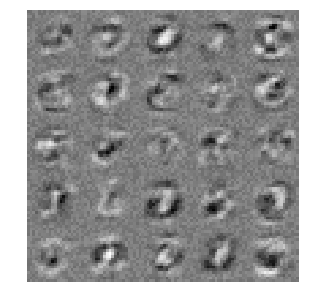

In [150]:
displayHiddenLayer(learned_thetas)